In [1]:
import numpy as np
from skimage import io,color,transform,morphology,measure,filters
from scipy.cluster.vq import vq, kmeans2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

(1171, 1485, 4)


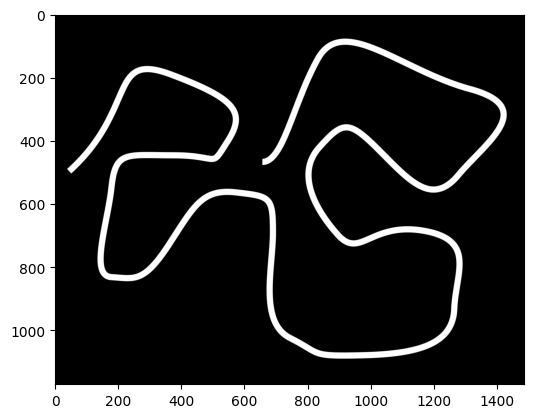

In [5]:
image = io.imread('./test.png') #io.imread('./trial2/Rb/DSC_0281.JPG')
print(image.shape)
plt.imshow(image)


255 0


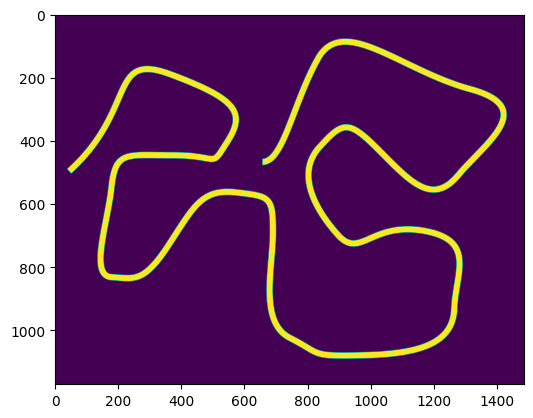

In [8]:
channel = image[:,:,1]
print(np.max(channel),np.min(channel))
plt.imshow(channel)


125


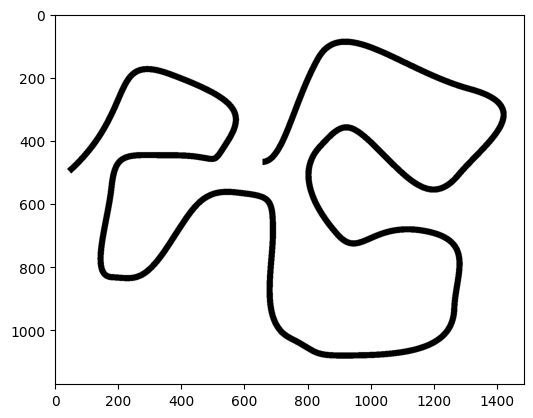

In [9]:
threshold = filters.threshold_isodata(channel)
print(threshold)
#threshold=100
mask = channel>threshold
plt.imshow(mask,cmap='binary')

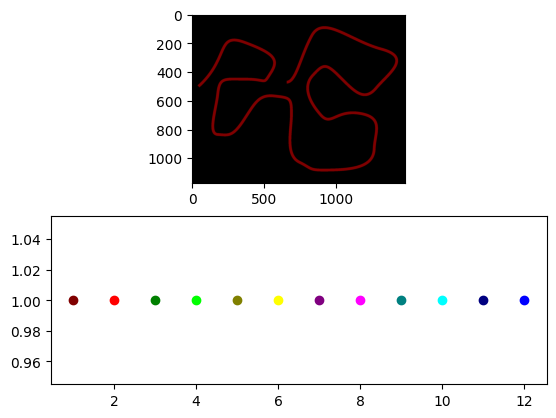

In [10]:
cleaned = morphology.remove_small_objects(mask,5000)
cleaned = morphology.remove_small_holes(cleaned,500) 
islands =  measure.label(cleaned)
colors = [[.5,0,0],[1,0,0],[0,.5,0],[0,1,0],[.5,.5,0],[1,1,0],[.5,0,.5],[1,0,1],[0,0.5,0.5],[0,1,1],[0,0,0.5],[0,0,1]]
fig,axs=plt.subplots(2,1)
axs[0].imshow(color.label2rgb(islands,colors=colors))
i=1
for c in colors:
    axs[1].plot(i,1,'o',color=c)
    i+=1

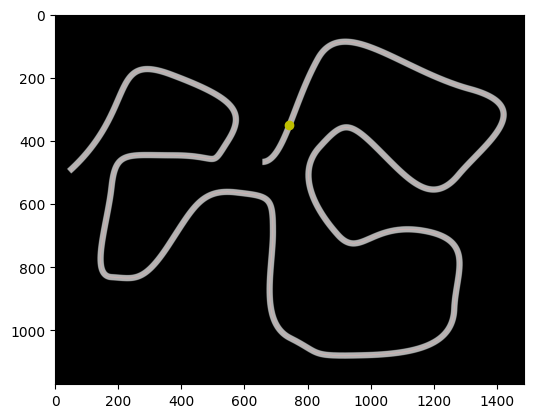

In [13]:
iFil=1 #set this manually
filament = islands==iFil
filament = morphology.skeletonize(filament)
colorised = color.label2rgb(filament, bg_label=0, image=color.rgba2rgb(image)) #if image was png, convert to rgb
plt.imshow(colorised)
M= int(filament.shape[1]/2)
L = np.where(filament[:,M])[0][0]
plt.plot(M,L,'yo')

In [14]:
def findnext(x,y,dx,dy,skinny,delta,R,limit=4,ax=None):
    xc = x + int(delta*dx/np.sqrt(dx**2+dy**2))
    yc = y + int(delta*dy/np.sqrt(dx**2+dy**2))
    if ax is not None:
        ax.plot(yc,xc, 'yo')     
    for i in range(limit):
        square = skinny[yc-R:yc+R,xc-R:xc+R]
        if np.sum(square)>0:
            break
        R *= 2
    else:
        raise ValueError
    dy,dx = measure.centroid(square)    
    return xc+int(dx-R),yc+int(dy-R)

def crawl(x,y,dx,dy,skinny,step,radius):
    while True:
        try:
            xnew,ynew = findnext(x[-1],y[-1],dx,dy,skinny,step,radius)           
        except ValueError:
            break
        dx = xnew-x[-1]
        dy = ynew-y[-1] 
        x.append(xnew)
        y.append(ynew)  
    return x,y

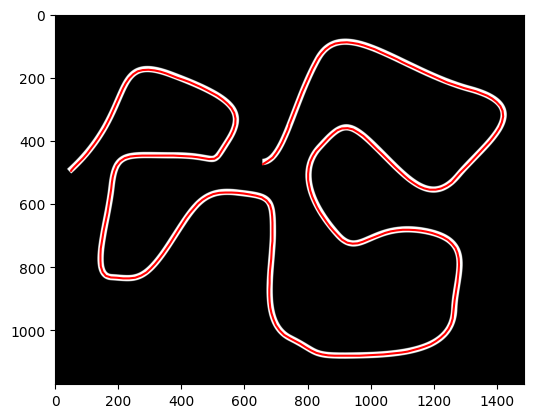

In [15]:
step = 20
radius = 2
x = y = []
start = [L, M]
x1 = [M]
y1 = [L]
x1,y1 = crawl(x1,y1,-1,-1,filament,step,radius)
x2 = [M]
y2 = [L]
x2,y2 = crawl(x2,y2,1,1,filament,step,radius)
x = np.append(x2[::-1] ,x1[1:])
y = np.append(y2[::-1] ,y1[1:])        
plt.imshow(image)
plt.plot(x,y, 'r-')

In [25]:
def tcos(v1,v2):
    out = np.dot(v1,v2)/np.linalg.norm(v1,ord=1)/np.linalg.norm(v2,ord=1)
    return out
def thetaApprox(x,y,N=100):
    dist = np.arange(1,N)
    costheta = []
    for d in dist:
        cos=[]
        pos=[]
        for i in range(0,len(x)-d-2):
            v1 = np.array([x[i+1]-x[i],y[i+1]-y[i]])
            v2 = np.array([x[i+d+1]-x[i+d],y[i+d+1]-y[i+d]])
            cangle = tcos( v1,v2 )
            cos.append(cangle)
        costheta.append(np.average(cos))
    return dist,costheta
def angle(v):
    uv = v/np.linalg.norm(v,ord=1)
    rad = np.arccos(np.dot(uv,[1,0]))
    if uv[1]<0:
        rad=2*np.pi-rad
    return rad
def theAngle(x,y):
    dist = []
    cumd=0
    theta = []
    for i in range(1,len(x)):
        v = [x[i]-x[i-1],y[i]-y[i-1]]
        dist.append(cumd)
        cumd+=np.linalg.norm(v,ord=1)
        theta.append(angle(v))    
    return dist,theta

def thetaNice(x,y,N=100):
    dist,theta = theAngle(x,y)
    delta = dist[1]
    xnew = np.arange(0,dist[-1],delta)
    ynew = np.interp(xnew, dist, theta)
    idist = np.arange(1,N)
    costheta=[]
    for d in idist:
        cos=[]
        for i in range(0,len(xnew)-d-2):
            dtheta = ynew[i+d+1]-ynew[i]
            cos.append(np.cos( dtheta ))
        costheta.append(np.average(cos))
    return idist*delta,costheta

322


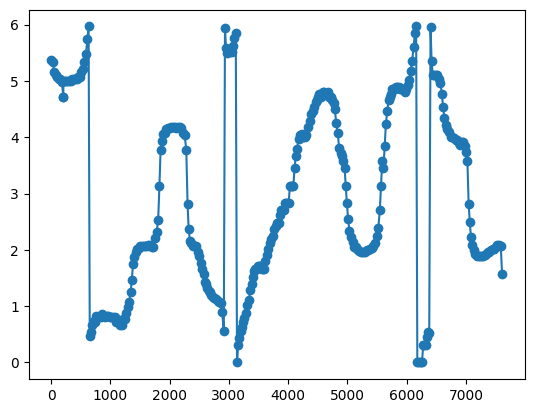

In [21]:
print(len(x))
dist,costheta = theAngle(x,y)
plt.plot(dist,costheta,'-o')

322


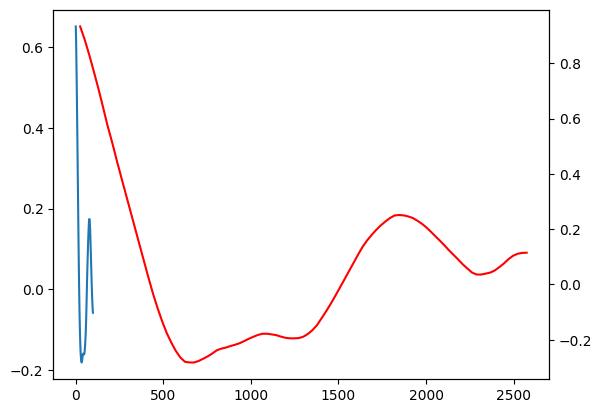

In [26]:
print(len(x))
N=100
fig,ax = plt.subplots()
ax2=ax.twinx()
dist,costheta = thetaApprox(x,y,N)
ax.plot(dist,costheta,'-')
dist,costheta = thetaNice(x,y,N)
ax2.plot(dist,costheta,'r-')